# Kernel - Principal Component Analysis

Muitos algoritmos de aprendizado de máquina assumem que os dados possam ser separados com uma função linear. O perceptron mesmo requer que os dados sejam perfeitamente separáveis para que ocorra convergência no treinamento. 

Outros algoritmos, como a regressão logística, consideram a que a falta de separabilidade linear se deva a ruidos e anomalias. No entanto, quando lidamos com problemas não lineares, os quais são encontrados com bastante frequência em aplicações reais, redução de dimensionalidade utilizando técnicas lineares, como o PCA e a LDA, podem não funcionar muito bem.

Nessa aula, veremos como a versão _kernelizada_ do PCA, ou KPCA, transforma dados que não são linearmente separáveis, em um sub-espaço de menor dimensão onde os dados podem ser linearmente separáveis. 

## Implementando o KPCA

No exemplo a seguir, utilizaremos os pacotes SciPy e NumPy para implementar nossa versão do KPCA:

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh

%matplotlib inline

In [2]:
def rbf_kernel_pca(X, gamma, n_components):
    """
    Implementação do PCA com kernel RBF (Radial Basis Function).    
    Parametros
    ------------
    X: {numpy ndarray}, shape = [n_examples, n_features]  
    
    gamma: float
        Parametro de ajuste do kernel RBF
    n_components: int
        Numero de componentes (features) a ser retornado    
    
    Retorna
    ------------
    X_pc: {numpy ndarray}, shape = [n_examples, k_features]
        Dataset projetado no novo espaco  
    """
    # Computa a distancia euclidiana entre todos os pares de amostras no espaco original.
    sq_dists = pdist(X, 'sqeuclidean')    
    
    # Converte as distancias entre os pares em uma matriz quadrada.
    mat_sq_dists = squareform(sq_dists)
    
    # Computa a matriz de kernels simetricos.
    K = exp(-gamma * mat_sq_dists) # gamma = sigma^-2 = 1/sigma^2
    
    # centraliza a matriz de kernels.
    M = K.shape[0]
    one_n = np.ones((M, M)) / M
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n) # -> K^{~} -> Matriz Gram
    
    # Obtem os 'autopares' da matriz de kernels centralizada
    # a funcao scipy.linalg.eigh retorna esses valores em ordem ascendenter
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]    
    
    # Pega os k primeiros autovetores na nova projecao
    X_pc = np.column_stack([eigvecs[:, i]
                           for i in range(n_components)])    
    return X_pc

Uma desvantagem de usar o PCA com kernel RBF para redução de dimensionalidade é que precisamos especificar o parâmetro _gamma_ a priori. Encontrar o valor apropriado requer experimentar diversos valores, e talvez usar alguma técnica de otimização de parametros, como por exemplo _grid search_.

## Examplo — separando dados em formato de meia lua

Vamos aplicar nosso PCA com kernel RBF em um dataset não linear. 

Começamos criando um dataset bi-dimensional com 100 amostras representando duas formas de meia lua:

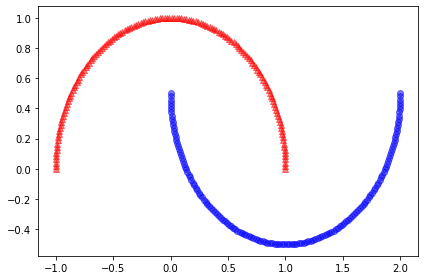

In [3]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, random_state=123)

plt.scatter(X[y==0, 0], X[y==0, 1],
    color='red', marker='^', alpha=0.5)

plt.scatter(X[y==1, 0], X[y==1, 1],
    color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

Para uma melhor visualização, a meia lua de triângulos representa uma classe, enquanto os círculos representam a outra classe.

Podemos ver claramente que as duas meia luas não são linearmente separáveis, e nosso objetivo é desdobrar as meia luas via KPCA, para que o dataset possa servir como uma entrada boa o suficiente para um classificador linear. 

Primeiramente, vamos ver como fica o dataset se fizermos a projeção utilizando o PCA tradicional:

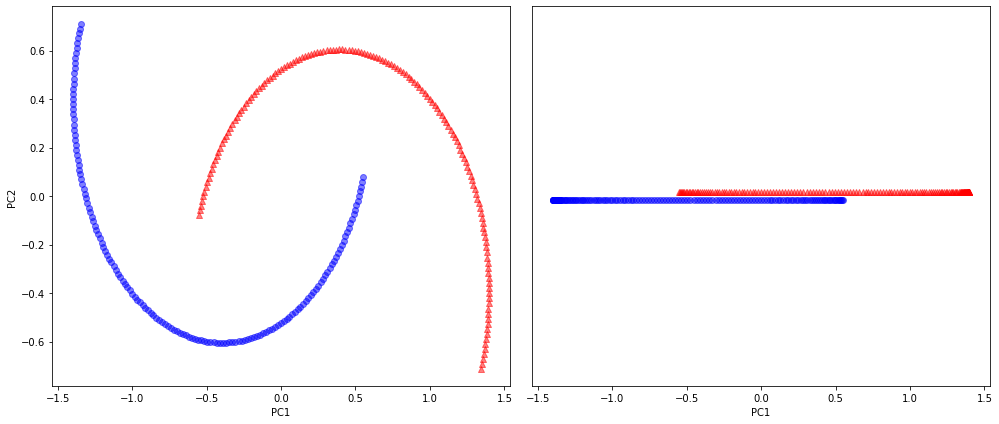

In [4]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],
              color='blue', marker='o', alpha=0.5)

# scatter 2 com projeção em pc1 didática
ax[1].scatter(X_spca[y==0, 0], np.zeros((150,1))+0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((150,1))-0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

A projeção acima deixa bem claro que um classificador linear não seria capaz de executar uma predição adequada dos dados transformados utilizando o PCA tradicional.

Notem que, ao plotarmos apenas os componentes principais (à direita), deslocamos os triângulos ligeiramente pra cima, e os círculos um pouco para baixo, visando visualizar melhor a sobreposição das classes. 

Essa transformação não ajudaria um classificador linear a discriminar entre os círculos e triângulos. 

Agora vamos tentar com nosso PCA de kernel RBF, implementado acima:

/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead


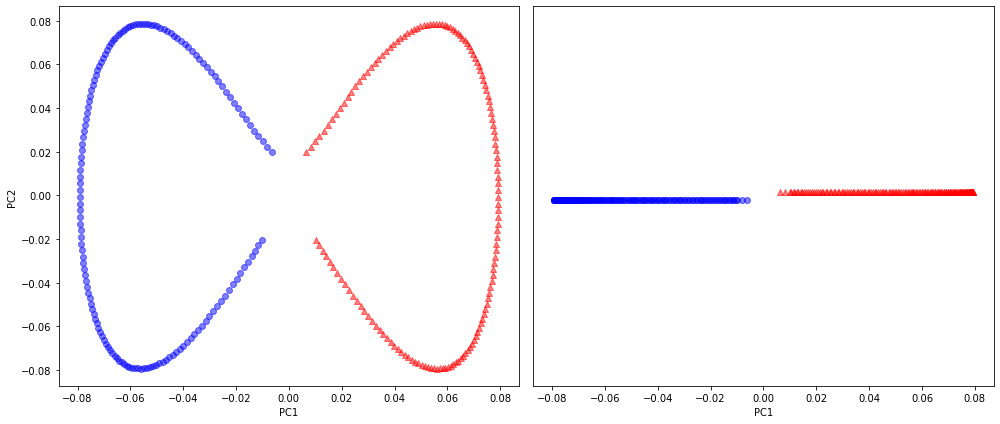

In [5]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((150,1))+0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((150,1))-0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

Podemos observar que as duas classes (círculos e triângulos) são linearmente separáveis, de modo que temos um dataset adequado para treinar um classificador linear.

Infelizmente, não existe um valor universal para o parametro `gamma` que funcione bem em qualquer dataset. 

Encontrar esse valor requer experimentar diferentes valores. Nesse caso, um valor de `gamma=15` foi capaz de proporcionar um bom resultado.

## Conclusões:

Nessa aula implementamos o PCA com Kernel RBF. 

Usamos o `kernel trick` e uma projeção temporária em um espaço de maior dimensão.

O algoritmo é capaz de comprimir datasets compostos de características não lineares em um sub-espaço de menor dimensionalidade, onde as amostras de classes diferentes são linearmente separaveis.

# Exercícios

Considerando o seguinte dataset:

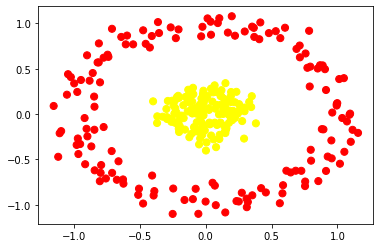

In [6]:
from sklearn.datasets import make_circles
X, y = make_circles(300, factor=.2, noise=.1)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.show()

#### 1. Transforme o dataset MNIST usando o KPCA. Encontre o valor de `gamma` que maximiza a separabilidade. 

#### 2. Transforme o mesmo dataset para uma menor dimensionalidade utilizando PCA e LDA. Utilize as transformações para alimentar um algoritmo de classificação linear (Perceptron, regressão logistica, etc). Compare os resultados com o KPCA otimizado.